# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük
az alábbi szerzőt értesíteni.

2019 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu),
Gyires-Tóth Bálint, Zainkó Csaba


Original Denoising AutoEncoder example from:

Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
    [Keras Denoising AutoEncoder] https://blog.keras.io/building-autoencoders-in-keras.html
</pre>

In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

Using TensorFlow backend.


In [0]:
input_img = Input(shape=(28,28,1))

In [0]:
# enkóder
x = Convolution2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Convolution2D(32, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# itt (7x7x32)-es reprezentáció

In [0]:
# dekóder
x = Convolution2D(32, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Convolution2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Convolution2D(1, (3,3), activation='sigmoid', padding='same')(x)

In [8]:
# teljes AE háló
autoencoder = Model(inputs = input_img, outputs = decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adadelta', loss = 'binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [9]:
# tanítóadatok
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _) ,(x_test, _) = mnist.load_data()

print(x_train.shape, x_test.shape)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# azért kell 4D-re átalakítani, mert a Convolution2D bemenete: (samples, rows, cols, channels)
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [0]:
# fehérzaj hozzákeverése a tanítóadatokhoz
noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

In [0]:
# 0-1 közé
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

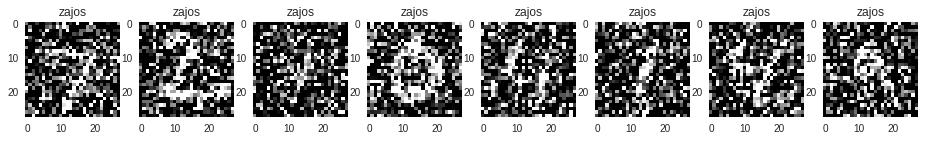

In [27]:
# zajos képek
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(1, n, i + 1)
  ax.set_title('zajos')
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()
  ax.grid('False')

In [28]:
# tanítás
# bemenet: zajos képek
# kimenet: eredeti (zajmentes) képek
autoencoder.fit(x_train_noisy, x_train,
               epochs = 5,
               batch_size = 128,
               shuffle = True,
               validation_data = (x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.1290 - val_loss: 0.1263
Epoch 2/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.1272 - val_loss: 0.1253
Epoch 3/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.1263 - val_loss: 0.1252
Epoch 4/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.1257 - val_loss: 0.1237
Epoch 5/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.1250 - val_loss: 0.1232


In [0]:
decoded_imgs = autoencoder.predict(x_test_noisy)

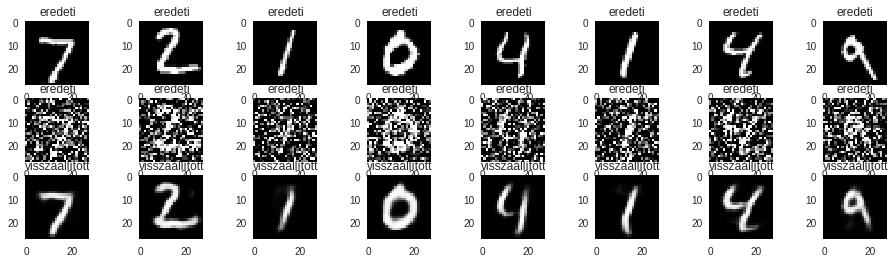

In [30]:
# eredeti, zajos és visszaállított képek kirajzolása
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(3, n, i + 1)
  ax.set_title('eredeti')
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()
  ax.grid('False')
  
  # zajos
  ax = plt.subplot(3, n, i + 1 + n)
  ax.set_title('eredeti')
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()
  ax.grid('False')
  
  # visszaállított
  ax = plt.subplot(3, n, i + 1 + 2 * n)
  ax.set_title('visszaállított')
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()  
  ax.grid('False')
plt.show()